# Electricity Price Anomaly Detection and Analysis

This analysis performs comprehensive anomaly detection and analysis on electricity price data from Romania using machine learning techniques, specifically Isolation Forest for anomaly detection and SHAP (SHapley Additive exPlanations) for explainability.

## Cell-by-Cell Breakdown

### Initial Setup Cell

**Purpose**: Initial environment setup
- Checks if GPU (CUDA) is available for potential acceleration
- Mounts Google Drive to access the dataset
- Sets the file path to the Romania electricity data CSV file

### Data Loading Cell

**Purpose**: Data loading and initial preprocessing
- Loads the CSV file containing electricity market data
- Displays the first few rows to understand the data structure
- Renames the price column to a simpler format for easier handling

### Feature Engineering Cell

**Purpose**: Creates temporal features for analysis
- Extracts hour of the day from the time column (0-23)
- Creates day of week feature (1-7, where 1=Monday)
- These temporal features help identify time-based patterns in anomalies

### Cell 1: Library Imports and Data Sampling

**Purpose**: Imports all necessary libraries and prepares data
- Imports machine learning libraries (sklearn), visualization (matplotlib, seaborn)
- Imports SHAP for model explainability
- Sets random seed for reproducible results
- Reduces dataset to last 10,000 rows for faster processing

### Cell 2: Data Cleaning and Preprocessing

**Purpose**: Comprehensive data cleaning
- Removes unnecessary columns
- Identifies and handles rows with excessive missing values (>50% NaN)
- Implements strategic NaN filling:
  - Price column: forward/backward fill to maintain price continuity
  - Other numeric columns: fill with 0
  - Non-numeric columns: forward fill
- Ensures no missing values remain in the dataset

### Cell 3: Exploratory Data Analysis and Preprocessing

**Purpose**: Data exploration and feature preparation
- Creates a proper datetime index for time series analysis
- Selects relevant features including:
  - Electricity load (actual and forecasted)
  - Various generation sources (gas, hydro, nuclear, solar, wind)
  - Generation forecasts
- Standardizes features using StandardScaler for anomaly detection
- Visualizes price distribution and time series

### Cell 4: Isolation Forest Anomaly Detection

**Purpose**: Anomaly detection using Isolation Forest
- **Key Design Decision**: Excludes price from training features to detect anomalies in underlying market conditions that cause price anomalies
- Uses Isolation Forest with:
  - 100 estimators for robust detection
  - 2% contamination rate (expects 2% of data to be anomalous)
- Generates anomaly labels and scores
- Visualizes detected anomalies on price time series

### Cell 5: Predictive Model Training for SHAP Analysis

**Purpose**: Trains a predictive model for explainability analysis
- Creates features (X) and target (y) for supervised learning
- Splits data into training/testing sets (80/20 split)
- Trains Random Forest Regressor to predict electricity prices
- Evaluates model performance using R² score
- Analyzes feature importance to understand which factors most influence prices

### Cell 6: SHAP Explainability Analysis

**Purpose**: Explains anomalies using SHAP values
- Creates SHAP TreeExplainer for the trained Random Forest model
- Focuses analysis specifically on detected anomalies
- Computes SHAP values to understand which features contribute most to anomalous predictions
- Generates summary plots showing feature impact on anomalous prices
- Provides both bar plots (feature importance) and beeswarm plots (feature effects)

### Cell 7: Anomaly Type Classification

**Purpose**: Categorizes anomalies by type
- Defines statistical thresholds (mean ± 2 standard deviations)
- Classifies anomalies into three categories:
  - **Price spikes**: High price anomalies
  - **Price drops**: Low price anomalies  
  - **Other anomalies**: Anomalies with normal price range
- Analyzes patterns in different anomaly types
- Visualizes anomaly types on the price time series

### Cell 8: Detailed Anomaly Cause Analysis

**Purpose**: Deep-dive analysis of anomaly causes
- Creates a function to analyze specific anomaly types
- Computes SHAP values for each anomaly type
- Identifies top contributing features for each type
- Compares feature values between anomalous and normal periods
- Calculates percentage deviations from normal behavior
- Provides detailed explanations for:
  - Price spike anomalies
  - Price drop anomalies
  - Other types of anomalies

### Cell 9: Comprehensive Anomaly Reporting

**Purpose**: Generates comprehensive anomaly reports
- Creates a structured reporting function
- Provides summary statistics:
  - Total records and anomalies
  - Anomaly percentage
  - Breakdown by anomaly type
- Analyzes temporal patterns:
  - Hourly distribution of anomalies
  - Day-of-week patterns
- Identifies most extreme cases
- Generates structured output for:
  - Period analysis
  - Summary statistics
  - Time-based patterns
  - Extreme case identification

## Overall Workflow Summary

1. **Data Loading & Preparation**: Load electricity market data and create temporal features
2. **Data Cleaning**: Handle missing values and prepare clean dataset
3. **Feature Engineering**: Select and scale relevant features for analysis
4. **Anomaly Detection**: Use Isolation Forest to identify unusual market conditions
5. **Predictive Modeling**: Train Random Forest for price prediction
6. **Explainability**: Use SHAP to understand what causes anomalous prices
7. **Anomaly Classification**: Categorize anomalies by type (spikes, drops, other)
8. **Detailed Analysis**: Investigate specific causes for each anomaly type
9. **Reporting**: Generate comprehensive reports with patterns and insights

## Key Insights Generated

- **Temporal Patterns**: When anomalies occur (hour of day, day of week)
- **Feature Importance**: Which market factors most influence price anomalies
- **Anomaly Types**: Classification of different types of price anomalies
- **Root Causes**: SHAP explanations for why specific anomalies occurred
- **Market Conditions**: Understanding of underlying factors during anomalous periods

In [1]:
import torch

# Vérifier si CUDA (et donc un GPU) est disponible
if torch.cuda.is_available():
    print("GPU est disponible et utilisé.")
else:
    print("GPU n'est pas disponible.")


GPU est disponible et utilisé.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/XAI_paper/Romania_merged_data.csv'

import pandas as pd

merged_data = pd.read_csv(file_path)
print(merged_data.head())

      Datetime (Local)  Price (EUR/MWhe)        date      time  \
0  2017-12-31 23:00:00             20.01  2017-12-31  23:00:00   
1  2018-01-01 00:00:00              4.29  2018-01-01  00:00:00   
2  2018-01-01 01:00:00              4.29  2018-01-01  01:00:00   
3  2018-01-01 02:00:00              0.22  2018-01-01  02:00:00   
4  2018-01-01 03:00:00              0.21  2018-01-01  03:00:00   

   Actual_generation_MW_fossil_gas_Romania  \
0                                      NaN   
1                                   1128.0   
2                                   1115.0   
3                                   1115.0   
4                                   1116.0   

   Actual_generation_MW_fossil_oil_Romania  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   Actual_generation_MW_hydro_run_of_river_et_pou

In [4]:
# Rename the price column in the merged_data dataframe
merged_data = merged_data.rename(columns={'Price (EUR/MWhe)': 'price'})

In [5]:
# Method 1: Using the existing 'time' column for hour_of_day
# Extract hour from the time column (assuming it's in HH:MM:SS format)
merged_data['hour_of_day'] = pd.to_datetime(merged_data['time'], format='%H:%M:%S').dt.hour

# Method 2: Alternative - using the 'Datetime (Local)' column for hour_of_day
# merged_data['hour_of_day'] = pd.to_datetime(merged_data['Datetime (Local)']).dt.hour

# Create day_of_week column using the date column (1=Monday, 2=Tuesday, ..., 7=Sunday)
# Convert date column to datetime if it's not already
merged_data['day_of_week'] = pd.to_datetime(merged_data['date']).dt.dayofweek + 1

# Alternative: Get day of week as names
# merged_data['day_of_week_name'] = pd.to_datetime(merged_data['date']).dt.day_name()

# Display the first few rows to verify
print("First few rows with new columns:")
print(merged_data[['Datetime (Local)', 'date', 'time', 'hour_of_day', 'day_of_week']].head())

# Check data types
print("\nData types:")
print(merged_data[['hour_of_day', 'day_of_week']].dtypes)

First few rows with new columns:
      Datetime (Local)        date      time  hour_of_day  day_of_week
0  2017-12-31 23:00:00  2017-12-31  23:00:00           23            7
1  2018-01-01 00:00:00  2018-01-01  00:00:00            0            1
2  2018-01-01 01:00:00  2018-01-01  01:00:00            1            1
3  2018-01-01 02:00:00  2018-01-01  02:00:00            2            1
4  2018-01-01 03:00:00  2018-01-01  03:00:00            3            1

Data types:
hour_of_day    int32
day_of_week    int32
dtype: object


In [6]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import shap
import datetime

# For reproducibility
np.random.seed(42)

In [7]:
# Keep only the last 10,000 rows
merged_data = merged_data.tail(10000)

In [8]:
# Cell 2: Load and clean the dataset
# Using the existing merged_data dataframe

# Start with the existing dataframe
df = merged_data.copy()

# Check what columns exist in the dataframe
print("Available columns:")
print(df.columns.tolist())
print("\nDataframe info:")
print(df.info())


# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'date time']  # Drop the original datetime column too
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Check for rows with too many NaN values
print("\nChecking for problematic rows...")
nan_threshold = 0.5  # If more than 50% of values are NaN, consider the row problematic
nan_percentage = df.isnull().sum(axis=1) / len(df.columns)
problematic_rows = nan_percentage > nan_threshold
print(f"Number of problematic rows: {sum(problematic_rows)}")

# Fill NaN values strategically
print("\nFilling NaN values...")

# Get numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# For price column, use forward fill and backward fill
if 'price' in df.columns:
    print("Filling price column...")
    df['price'] = df['price'].fillna(method='ffill').fillna(method='bfill')

# For other numeric columns, fill with 0
for col in numeric_columns:
    if col != 'price':
        df[col] = df[col].fillna(0)

# For non-numeric columns, fill with forward fill
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_columns:
    if col not in ['date', 'time']:  # Skip date and time columns
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

# Final check - fill any remaining NaN with 0
df = df.fillna(0)

# Display the results
print("\nDataset info after cleaning:")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Check for any remaining NaN values
print("\nNaN values per column after cleaning:")
nan_summary = df.isnull().sum()
print(nan_summary[nan_summary > 0])  # Only show columns with NaN values

# Display basic statistics for key columns
print("\nBasic statistics for key columns:")
key_columns = ['price', 'Actual_total_load_MW_Romania', 'temperature_2m (°C)', 'hour_of_day', 'day_of_week']
available_key_columns = [col for col in key_columns if col in df.columns]
print(df[available_key_columns].describe())

Available columns:
['Datetime (Local)', 'price', 'date', 'time', 'Actual_generation_MW_fossil_gas_Romania', 'Actual_generation_MW_fossil_oil_Romania', 'Actual_generation_MW_hydro_run_of_river_et_poundage_Romania', 'Actual_generation_MW_hydro_water_reservoir_Romania', 'Actual_generation_MW_nuclear_Romania', 'Actual_generation_MW_solar_Romania', 'Actual_generation_MW_wind_onshore_Romania', 'Actual_total_load_MW_Romania', 'Current_solar_generation_forecast_MW_Romania', 'Current_wind_onshore_generation_forecast_MW_Romania', 'Day_ahead_solar_generation_forecast_MW_Romania', 'Day_ahead_total_load_forecast_MW_Romania', 'Day_ahead_wind_onshore_generation_forecast_MW_Romania', 'Intraday_solar_generation_forecast_MW_Romania', 'Intraday_wind_onshore_generation_forecast_MW_Romania', 'hour_of_day', 'day_of_week']

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 44771 to 54770
Data columns (total 21 columns):
 #   Column                                               

/tmp/ipython-input-8-2414304101.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['price'] = df['price'].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-8-2414304101.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


Number of NaN values in each column:
price                                                          0
Actual_total_load_MW_Romania                                   0
Day_ahead_total_load_forecast_MW_Romania                       0
Actual_generation_MW_fossil_gas_Romania                        0
Actual_generation_MW_hydro_run_of_river_et_poundage_Romania    0
Actual_generation_MW_hydro_water_reservoir_Romania             0
Actual_generation_MW_nuclear_Romania                           0
Actual_generation_MW_solar_Romania                             0
Actual_generation_MW_wind_onshore_Romania                      0
Current_solar_generation_forecast_MW_Romania                   0
Current_wind_onshore_generation_forecast_MW_Romania            0
Day_ahead_solar_generation_forecast_MW_Romania                 0
Day_ahead_wind_onshore_generation_forecast_MW_Romania          0
Intraday_solar_generation_forecast_MW_Romania                  0
Intraday_wind_onshore_generation_forecast_MW_Romania 

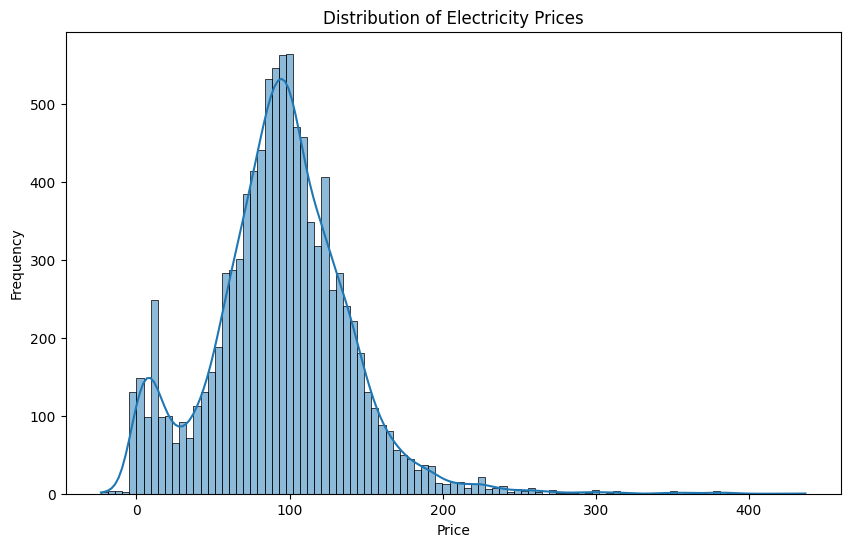

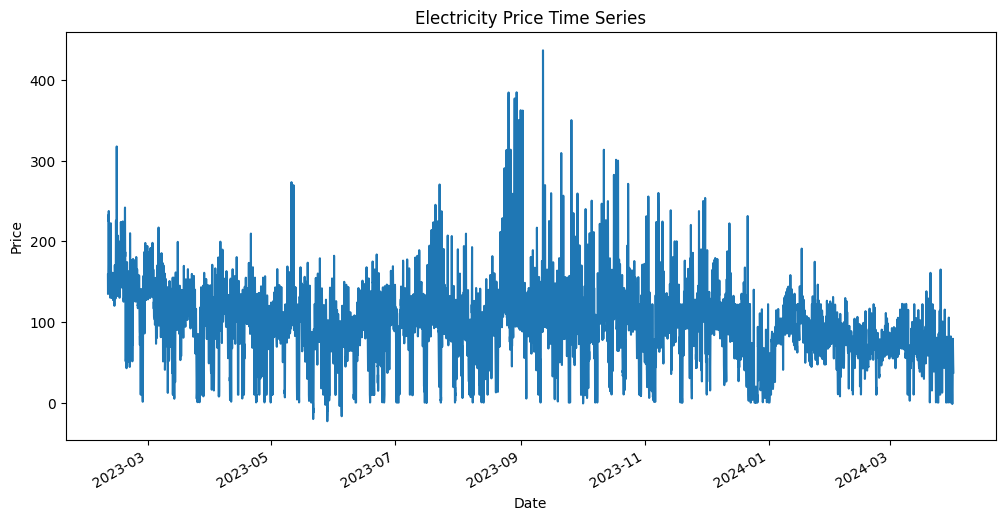

In [9]:
# Cell 3: Basic exploration and data preprocessing
# Create datetime column
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))
df = df.set_index('datetime')

# Select features for anomaly detection
features = [
    'price',
    'Actual_total_load_MW_Romania',
    'Day_ahead_total_load_forecast_MW_Romania',
    'Actual_generation_MW_fossil_gas_Romania',  # Updated: was fossil_oil, now fossil_gas
    'Actual_generation_MW_hydro_run_of_river_et_poundage_Romania',
    'Actual_generation_MW_hydro_water_reservoir_Romania',
    'Actual_generation_MW_nuclear_Romania',
    'Actual_generation_MW_solar_Romania',
    'Actual_generation_MW_wind_onshore_Romania',
    # Additional generation forecasts available in your dataset
    'Current_solar_generation_forecast_MW_Romania',
    'Current_wind_onshore_generation_forecast_MW_Romania',
    'Day_ahead_solar_generation_forecast_MW_Romania',
    'Day_ahead_wind_onshore_generation_forecast_MW_Romania',
    'Intraday_solar_generation_forecast_MW_Romania',
    'Intraday_wind_onshore_generation_forecast_MW_Romania'
]

# Create a dataframe with selected features
df_features = df[features].copy()

# Check for any remaining NaN values
print("Number of NaN values in each column:")
print(df_features.isna().sum())

# Scale the data for anomaly detection
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_features),
    columns=df_features.columns,
    index=df_features.index
)

# Basic statistics of price
print("\nPrice statistics:")
print(df['price'].describe())

# Visualize price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Electricity Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Visualize price over time
plt.figure(figsize=(12, 6))
df['price'].plot()
plt.title('Electricity Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Number of detected anomalies: 200 (2.00%)


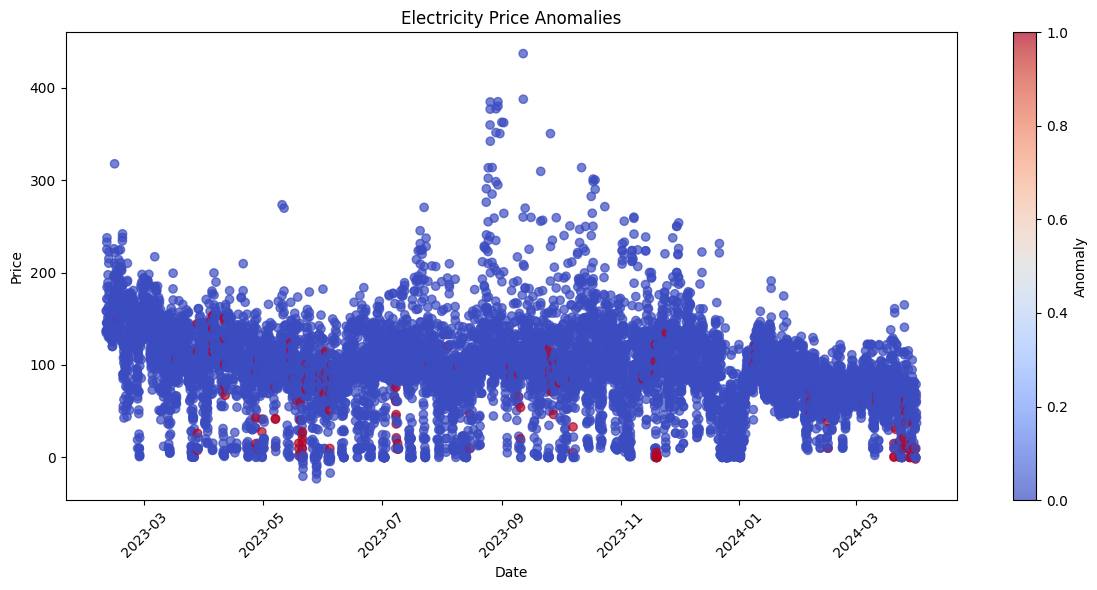

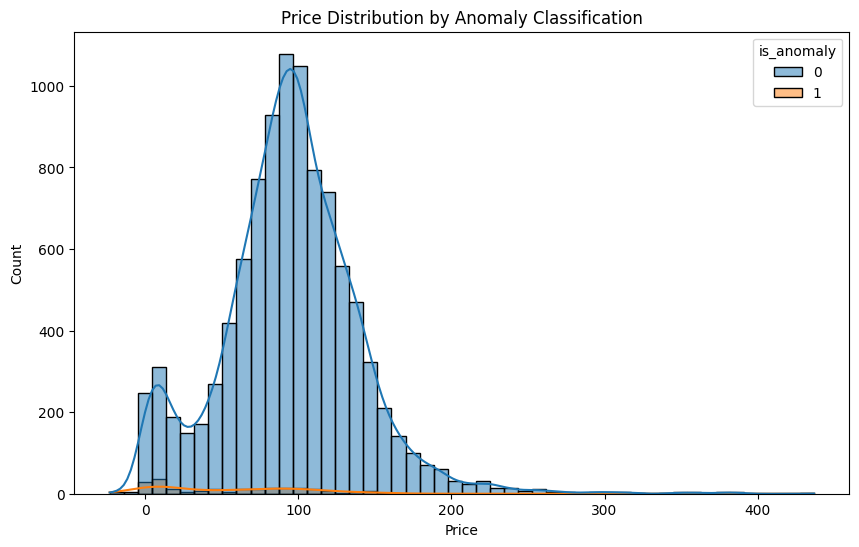

In [10]:
# Cell 4: Isolation Forest for Anomaly Detection
# Select features for anomaly detection
# Important: We need to decide whether to include or exclude price in anomaly detection
# Here we'll make sure to EXCLUDE price when training the model

# Define the features excluding price for anomaly detection
anomaly_features = [col for col in df_scaled.columns if col != 'price']

# Train Isolation Forest model on features excluding price
isolation_forest = IsolationForest(
    n_estimators=100,
    contamination=0.02,  # Expected proportion of anomalies
    random_state=42
)

# Fit the model on data excluding price column
isolation_forest.fit(df_scaled[anomaly_features])

# Predict anomalies (1 for normal, -1 for anomalies)
df['anomaly'] = isolation_forest.predict(df_scaled[anomaly_features])
df['anomaly_score'] = isolation_forest.decision_function(df_scaled[anomaly_features])

# Convert to binary classification (1 for anomalies, 0 for normal)
df['is_anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Count anomalies
anomaly_count = df['is_anomaly'].sum()
print(f"Number of detected anomalies: {anomaly_count} ({anomaly_count/len(df)*100:.2f}%)")

# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['price'], c=df['is_anomaly'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Anomaly')
plt.title('Electricity Price Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot price distribution by anomaly classification
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', hue='is_anomaly', bins=50, kde=True)
plt.title('Price Distribution by Anomaly Classification')
plt.xlabel('Price')
plt.show()

Model R² on training data: 0.9574
Model R² on test data: 0.7027

Feature importance:
                                              Feature  Importance
1            Day_ahead_total_load_forecast_MW_Romania    0.175828
0                        Actual_total_load_MW_Romania    0.136391
2             Actual_generation_MW_fossil_gas_Romania    0.119881
3   Actual_generation_MW_hydro_run_of_river_et_pou...    0.114044
10     Day_ahead_solar_generation_forecast_MW_Romania    0.102011
4   Actual_generation_MW_hydro_water_reservoir_Rom...    0.082153
5                Actual_generation_MW_nuclear_Romania    0.066610
7           Actual_generation_MW_wind_onshore_Romania    0.038336
12      Intraday_solar_generation_forecast_MW_Romania    0.035983
8        Current_solar_generation_forecast_MW_Romania    0.031663


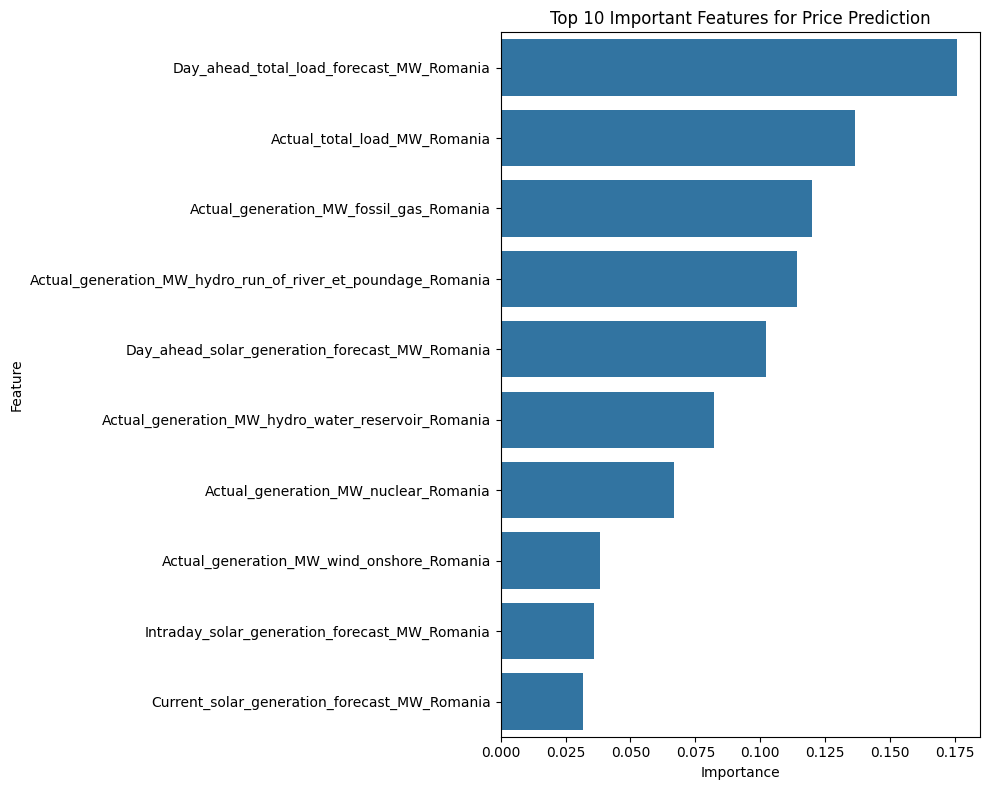

In [11]:
# Cell 5: Train a predictive model for SHAP explanations
# Prepare data for modeling
X = df_features.drop(columns=['price'])
y = df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a Random Forest model for price prediction
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) #//nb estmators=100
rf_model.fit(X_train, y_train)

# Evaluate model
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print(f"Model R² on training data: {train_score:.4f}")
print(f"Model R² on test data: {test_score:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature importance:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features for Price Prediction')
plt.tight_layout()
plt.show()

/tmp/ipython-input-12-1936348326.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_anomalies, plot_type="bar")


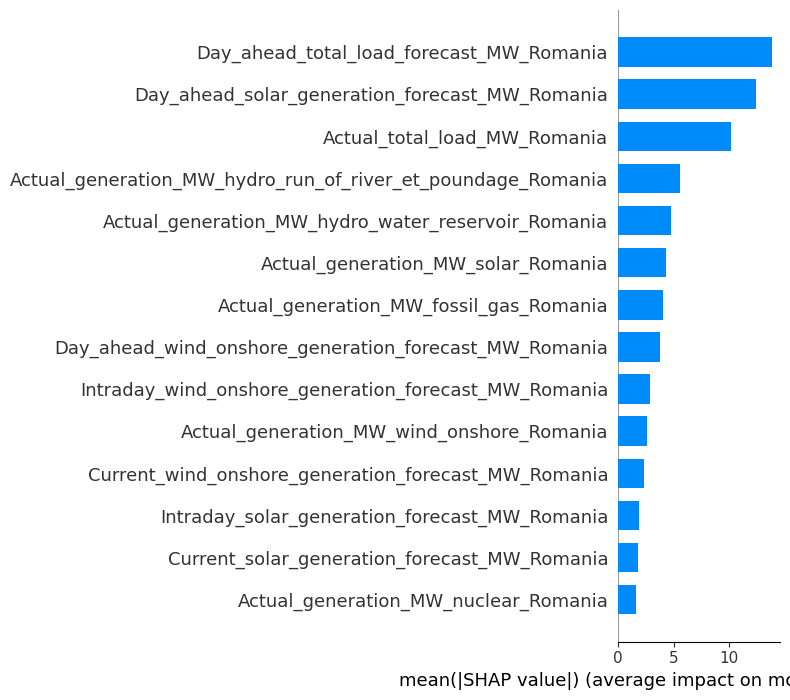

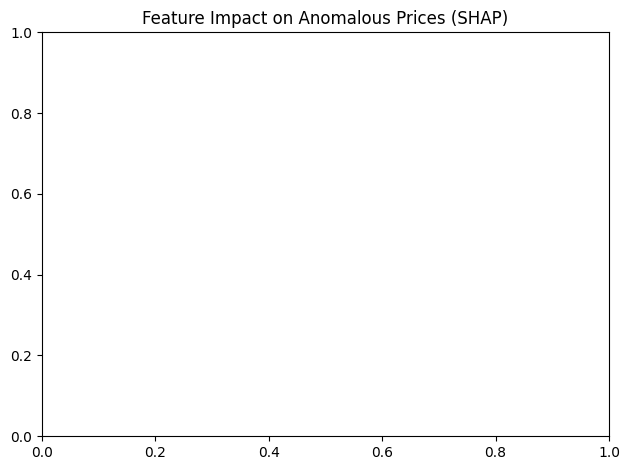

/tmp/ipython-input-12-1936348326.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_anomalies)


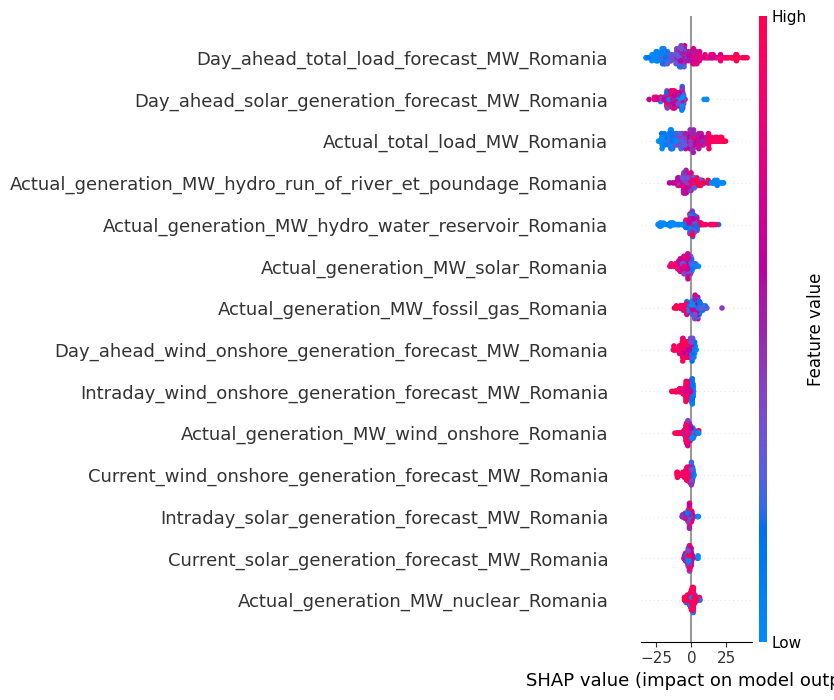

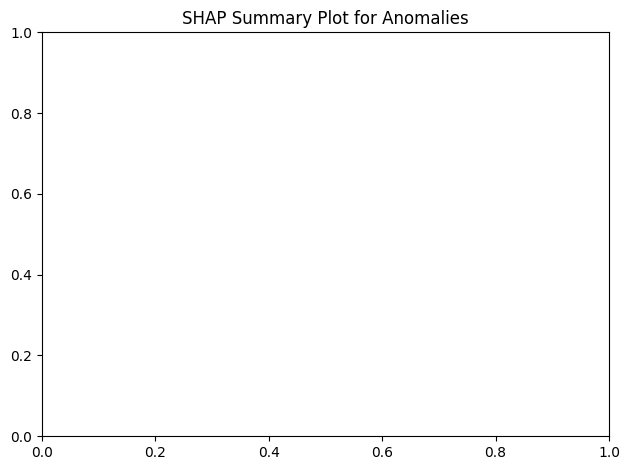

In [12]:
# Cell 6: SHAP analysis for anomaly explanation
# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Get anomaly indices
anomaly_indices = df[df['is_anomaly'] == 1].index

# Filter data for anomalies
X_anomalies = X.loc[anomaly_indices]

# Compute SHAP values for anomalies
shap_values = explainer.shap_values(X_anomalies)

# Summary plot of SHAP values for anomalies
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_anomalies, plot_type="bar")
plt.title('Feature Impact on Anomalous Prices (SHAP)')
plt.tight_layout()
plt.show()

# Detailed SHAP visualization
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_anomalies)
plt.title('SHAP Summary Plot for Anomalies')
plt.tight_layout()
plt.show()

Anomaly types:
anomaly_type
normal           9800
other_anomaly     173
price_drop         27
Name: count, dtype: int64

Average feature values by anomaly type:
                   price  Actual_total_load_MW_Romania  \
anomaly_type                                             
normal         94.626598                   6144.485714   
other_anomaly  64.631040                   5863.641618   
price_drop      0.367407                   5120.777778   

               Day_ahead_total_load_forecast_MW_Romania  \
anomaly_type                                              
normal                                      6155.972449   
other_anomaly                               6041.213873   
price_drop                                  5361.111111   

               Actual_generation_MW_fossil_gas_Romania  \
anomaly_type                                             
normal                                     1158.166735   
other_anomaly                               841.716763   
price_drop          

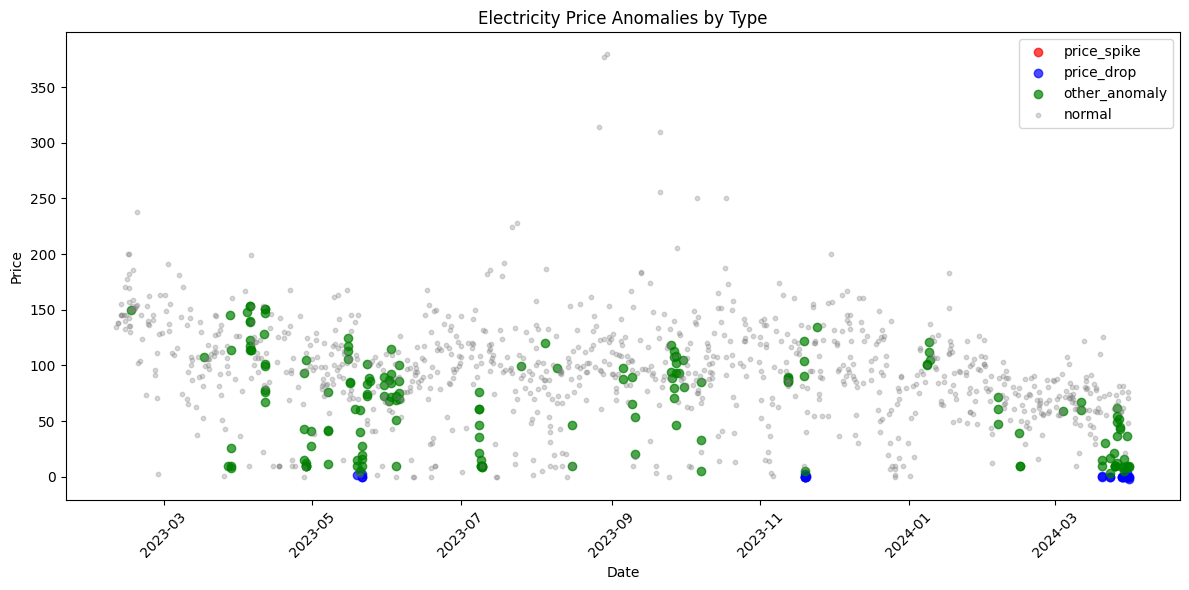

In [13]:
# Cell 7: Analyze specific types of anomalies
# Define extreme high and low price thresholds (based on domain knowledge)
high_price_threshold = df['price'].mean() + 2 * df['price'].std()
low_price_threshold = df['price'].mean() - 2 * df['price'].std()

# Classify anomalies by type
df['anomaly_type'] = 'normal'
df.loc[(df['is_anomaly'] == 1) & (df['price'] > high_price_threshold), 'anomaly_type'] = 'price_spike'
df.loc[(df['is_anomaly'] == 1) & (df['price'] < low_price_threshold), 'anomaly_type'] = 'price_drop'
df.loc[(df['is_anomaly'] == 1) &
       (df['price'] <= high_price_threshold) &
       (df['price'] >= low_price_threshold), 'anomaly_type'] = 'other_anomaly'

# Count anomalies by type
anomaly_type_counts = df['anomaly_type'].value_counts()
print("Anomaly types:")
print(anomaly_type_counts)

# Analyze patterns in different anomaly types
anomaly_patterns = df.groupby('anomaly_type')[features].mean()
print("\nAverage feature values by anomaly type:")
print(anomaly_patterns)

# Visualize anomaly types
plt.figure(figsize=(12, 6))
for anomaly_type, color in zip(['price_spike', 'price_drop', 'other_anomaly'], ['red', 'blue', 'green']):
    subset = df[df['anomaly_type'] == anomaly_type]
    plt.scatter(subset.index, subset['price'], c=color, label=anomaly_type, alpha=0.7)

# Add normal data points for reference (using a small sample for clarity)
normal_sample = df[df['anomaly_type'] == 'normal'].sample(min(1000, len(df[df['anomaly_type'] == 'normal'])))
plt.scatter(normal_sample.index, normal_sample['price'], c='gray', label='normal', alpha=0.3, s=10)

plt.legend()
plt.title('Electricity Price Anomalies by Type')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Cell 8: Detailed analysis of anomaly causes
# Function to analyze and explain specific anomalies
def explain_anomalies(anomaly_type):
    # Filter anomalies of specified type
    anomalies = df[df['anomaly_type'] == anomaly_type]

    if len(anomalies) == 0:
        return f"No anomalies of type '{anomaly_type}' found."

    # Get SHAP values for these anomalies
    X_subset = X.loc[anomalies.index]
    shap_values_subset = explainer.shap_values(X_subset)

    # Compute average absolute SHAP value for each feature
    avg_shap_impact = pd.DataFrame({
        'Feature': X.columns,
        'Impact': np.abs(shap_values_subset).mean(axis=0)
    }).sort_values('Impact', ascending=False)

    # Get top contributing features
    top_features = avg_shap_impact.head(5)['Feature'].tolist()

    # Analyze feature values for these anomalies
    feature_stats = anomalies[top_features].describe()

    # Compare with normal data
    normal_stats = df[df['anomaly_type'] == 'normal'][top_features].describe()

    # Calculate percentage difference from normal
    pct_diff = ((feature_stats.loc['mean'] - normal_stats.loc['mean']) / normal_stats.loc['mean'] * 100).round(2)

    return {
        'count': len(anomalies),
        'avg_price': anomalies['price'].mean(),
        'top_features': top_features,
        'feature_stats': feature_stats,
        'normal_stats': normal_stats,
        'pct_diff': pct_diff
    }

# Analyze each anomaly type
price_spike_analysis = explain_anomalies('price_spike')
price_drop_analysis = explain_anomalies('price_drop')
other_anomaly_analysis = explain_anomalies('other_anomaly')

# Print findings
print("\n=== PRICE SPIKE ANOMALIES ===")
if isinstance(price_spike_analysis, dict):
    print(f"Count: {price_spike_analysis['count']}")
    print(f"Average price: {price_spike_analysis['avg_price']:.2f}")
    print("\nTop contributing features and their deviation from normal:")
    for feature, diff in price_spike_analysis['pct_diff'].items():
        direction = "higher" if diff > 0 else "lower"
        print(f"- {feature}: {abs(diff):.2f}% {direction} than normal")
else:
    print(price_spike_analysis)

print("\n=== PRICE DROP ANOMALIES ===")
if isinstance(price_drop_analysis, dict):
    print(f"Count: {price_drop_analysis['count']}")
    print(f"Average price: {price_drop_analysis['avg_price']:.2f}")
    print("\nTop contributing features and their deviation from normal:")
    for feature, diff in price_drop_analysis['pct_diff'].items():
        direction = "higher" if diff > 0 else "lower"
        print(f"- {feature}: {abs(diff):.2f}% {direction} than normal")
else:
    print(price_drop_analysis)

print("\n=== OTHER ANOMALIES ===")
if isinstance(other_anomaly_analysis, dict):
    print(f"Count: {other_anomaly_analysis['count']}")
    print(f"Average price: {other_anomaly_analysis['avg_price']:.2f}")
    print("\nTop contributing features and their deviation from normal:")
    for feature, diff in other_anomaly_analysis['pct_diff'].items():
        direction = "higher" if diff > 0 else "lower"
        print(f"- {feature}: {abs(diff):.2f}% {direction} than normal")
else:
    print(other_anomaly_analysis)


=== PRICE SPIKE ANOMALIES ===
No anomalies of type 'price_spike' found.

=== PRICE DROP ANOMALIES ===
Count: 27
Average price: 0.37

Top contributing features and their deviation from normal:
- Day_ahead_total_load_forecast_MW_Romania: 12.91% lower than normal
- Day_ahead_solar_generation_forecast_MW_Romania: 351.95% higher than normal
- Actual_total_load_MW_Romania: 16.66% lower than normal
- Actual_generation_MW_hydro_water_reservoir_Romania: 70.96% lower than normal
- Actual_generation_MW_solar_Romania: 360.01% higher than normal

=== OTHER ANOMALIES ===
Count: 173
Average price: 64.63

Top contributing features and their deviation from normal:
- Day_ahead_total_load_forecast_MW_Romania: 1.86% lower than normal
- Day_ahead_solar_generation_forecast_MW_Romania: 272.84% higher than normal
- Actual_total_load_MW_Romania: 4.57% lower than normal
- Actual_generation_MW_hydro_run_of_river_et_poundage_Romania: 5.82% higher than normal
- Actual_generation_MW_fossil_gas_Romania: 27.32% lowe

In [15]:
# Cell 9: Generate a comprehensive anomaly report
def generate_anomaly_report(df, start_date=None, end_date=None):
    """
    Generate a comprehensive report of anomalies in the dataset

    Parameters:
    df: pandas DataFrame with anomaly detection results
    start_date, end_date: optional date range for the report

    Returns:
    dict: Report data
    """
    # Filter by date range if provided
    report_df = df.copy()
    if start_date and end_date:
        mask = (report_df.index >= start_date) & (report_df.index <= end_date)
        report_df = report_df.loc[mask]

    # Basic statistics
    total_records = len(report_df)
    total_anomalies = report_df['is_anomaly'].sum()
    anomaly_percentage = (total_anomalies / total_records) * 100

    # Anomaly types
    anomaly_types = report_df['anomaly_type'].value_counts().to_dict()

    # Time patterns (hour of day, day of week)
    hour_distribution = report_df[report_df['is_anomaly'] == 1]['hour_of_day'].value_counts().sort_index().to_dict()
    day_distribution = report_df[report_df['is_anomaly'] == 1]['day_of_week'].value_counts().sort_index().to_dict()

    # Find the most extreme anomalies
    most_extreme_high = report_df[report_df['anomaly_type'] == 'price_spike'].nlargest(5, 'price')
    most_extreme_low = report_df[report_df['anomaly_type'] == 'price_drop'].nsmallest(5, 'price')

    # Generate report
    report = {
        "period": {
            "start": report_df.index.min(),
            "end": report_df.index.max()
        },
        "summary": {
            "total_records": total_records,
            "total_anomalies": int(total_anomalies),
            "anomaly_percentage": round(anomaly_percentage, 2),
            "anomaly_types": anomaly_types
        },
        "patterns": {
            "hour_distribution": hour_distribution,
            "day_distribution": day_distribution
        },
        "extreme_cases": {
            "highest_prices": most_extreme_high[['price', 'anomaly_score']].to_dict(orient='records'),
            "lowest_prices": most_extreme_low[['price', 'anomaly_score']].to_dict(orient='records')
        }
    }

    return report

# Generate a sample report
report = generate_anomaly_report(df)
print("\n=== ANOMALY REPORT ===")
print(f"Period: {report['period']['start']} to {report['period']['end']}")
print(f"Total records: {report['summary']['total_records']}")
print(f"Total anomalies: {report['summary']['total_anomalies']} ({report['summary']['anomaly_percentage']}%)")
print("\nAnomaly types:")
for type_name, count in report['summary']['anomaly_types'].items():
    if type_name != 'normal':
        print(f"- {type_name}: {count}")

print("\nTime patterns:")
print("Hour distribution of anomalies:")
for hour, count in report['patterns']['hour_distribution'].items():
    print(f"- Hour {hour}: {count} anomalies")

print("\nDay of week distribution of anomalies:")
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day_num, count in report['patterns']['day_distribution'].items():
    print(f"- {days[day_num-1]}: {count} anomalies")

print("\nMost extreme price spikes:")
for i, case in enumerate(report['extreme_cases']['highest_prices'][:3], 1):
    print(f"{i}. Price: {case['price']:.2f}, Anomaly score: {case['anomaly_score']:.4f}")

print("\nMost extreme price drops:")
for i, case in enumerate(report['extreme_cases']['lowest_prices'][:3], 1):
    print(f"{i}. Price: {case['price']:.2f}, Anomaly score: {case['anomaly_score']:.4f}")


=== ANOMALY REPORT ===
Period: 2023-02-09 10:00:00 to 2024-04-01 02:00:00
Total records: 10000
Total anomalies: 200 (2.0%)

Anomaly types:
- other_anomaly: 173
- price_drop: 27

Time patterns:
Hour distribution of anomalies:
- Hour 5: 1 anomalies
- Hour 6: 2 anomalies
- Hour 7: 6 anomalies
- Hour 8: 11 anomalies
- Hour 9: 24 anomalies
- Hour 10: 41 anomalies
- Hour 11: 47 anomalies
- Hour 12: 37 anomalies
- Hour 13: 14 anomalies
- Hour 14: 11 anomalies
- Hour 15: 3 anomalies
- Hour 18: 1 anomalies
- Hour 19: 1 anomalies
- Hour 20: 1 anomalies

Day of week distribution of anomalies:
- Monday: 22 anomalies
- Tuesday: 44 anomalies
- Wednesday: 24 anomalies
- Thursday: 15 anomalies
- Friday: 21 anomalies
- Saturday: 29 anomalies
- Sunday: 45 anomalies

Most extreme price spikes:

Most extreme price drops:
1. Price: -1.80, Anomaly score: -0.0490
2. Price: -0.51, Anomaly score: -0.0450
3. Price: -0.41, Anomaly score: -0.0060
